# Message passing neural network for segment classification on ACTS data

In this notebook we'll implement a model similar to the Interaction Networks model:
https://arxiv.org/abs/1612.00222

The model will consider a graph of connected hits and try to determine which edges are real and which are spurious.

In [2]:
# Training concurrency
import os
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

cuda = True

In [3]:
%load_ext autoreload
%autoreload 2

# System imports
from __future__ import print_function
import os
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if cuda else "cpu")

# Local imports
from acts import process_hits_files, select_barrel_hits, select_hits
from graph import load_graphs, SparseGraph, graph_from_sparse
from model_maskedlinear import SegmentClassifier
from estimator_maskedlinear import Estimator

feature_scale = np.array([1000., np.pi/8, 1000.])

n_features = feature_scale.shape[0]
print(feature_scale)

%matplotlib inline

[1.00000000e+03 3.92699082e-01 1.00000000e+03]


In [4]:
if cuda:
    np_to_torch = lambda x, volatile=False, dtype=np.float32: (torch.tensor(x.astype(dtype), requires_grad=False).cuda())
else:
    np_to_torch = lambda x, volatile=False, dtype=np.float32: (torch.tensor(x.astype(dtype), requires_grad=False))

if cuda:
    torch_to_np = lambda x: x.cpu().numpy()
else:
    torch_to_np = lambda x: x.detach().numpy()

## Data utilities

## Prepare the data

In [5]:
#input_dir = '/data/ntran/prod_mu10_pt1000_2017_07_29'
#input_dir = '/cms-sc17/graphNN/prod_mu10_pt1000_2017_07_29'
input_dir = '/home/ec2-user/gnn-fpga/gnn/graphs_n-tracks10_z0-max400_phi-slope-max0p002_no-missing-hits/'

In [6]:
%%time
n_samples = 14160
filenames = [os.path.join(input_dir, 'graph%06i.npz' % i) for i in range(n_samples)]
graphs = load_graphs(filenames, SparseGraph)
print(len(graphs))

14160
CPU times: user 31.3 s, sys: 544 ms, total: 31.8 s
Wall time: 31.8 s


In [7]:
# Get the mean label for all the segments from all samples

# Flatten the labels array
flat_y = np.concatenate([g.y for g in graphs])

flat_y.mean()

0.3614505

## Define the data generator

Since every event is unique, we need something which can batch things together into batch-specific tensors.

It should just use the max size required for that sample.

In [8]:
def merge_graphs(graphs):
    batch_size = len(graphs)
    
    # Special handling of batch size 1
    if batch_size == 1:
        g = graphs[0]
        # Prepend singleton batch dimension
        return g.X[None], g.Ri[None], g.Ro[None], g.y[None]
    
    # Get the maximum sizes in this batch
    n_features = graphs[0].X.shape[1]
    n_nodes = np.array([g.X.shape[0] for g in graphs])
    n_edges = np.array([g.y.shape[0] for g in graphs])
    max_nodes = n_nodes.max()
    max_edges = n_edges.max()

    # Allocate the tensors for this batch
    batch_X = np.zeros((batch_size, max_nodes, n_features), dtype=np.float32)
    batch_Ri = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_Ro = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_y = np.zeros((batch_size, max_edges), dtype=np.uint8)

    # Loop over samples and fill the tensors
    for i, g in enumerate(graphs):
        batch_X[i, :n_nodes[i]] = g.X
        batch_Ri[i, :n_nodes[i], :n_edges[i]] = g.Ri
        batch_Ro[i, :n_nodes[i], :n_edges[i]] = g.Ro
        batch_y[i, :n_edges[i]] = g.y
    
    return batch_X, batch_Ri, batch_Ro, batch_y

def batch_generator(graphs, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            #print('batch', j, '-', j+batch_size)
            batch_graphs = [graph_from_sparse(g) for g in graphs[j:j+batch_size]]
            batch_X, batch_Ri, batch_Ro, batch_y = merge_graphs(batch_graphs)
            #print('  graphs merged')
            batch_inputs = [
                np_to_torch(batch_X, volatile=volatile),
                np_to_torch(batch_Ri, volatile=volatile),
                np_to_torch(batch_Ro, volatile=volatile)]
            batch_target = np_to_torch(batch_y, volatile=volatile)
            #print('  data prepared')
            yield batch_inputs, batch_target

### Visualize one sample

Need to put this code into a function, and write it so it will be easy to use
at model evaluation time (e.g., using model representation of the data).

In [8]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    """
    TODO: make segment coloring configurable.
    """
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    #ax0.set_xlim(-1100, 1100)
    ax1.set_xlim(-np.pi/8, np.pi/8)
    ax0.set_xlabel('$z$ [mm]')
    ax1.set_xlabel('$\phi$ [rad]')
    ax0.set_ylabel('$r$ [mm]')
    ax1.set_ylabel('$r$ [mm]')
    plt.tight_layout()

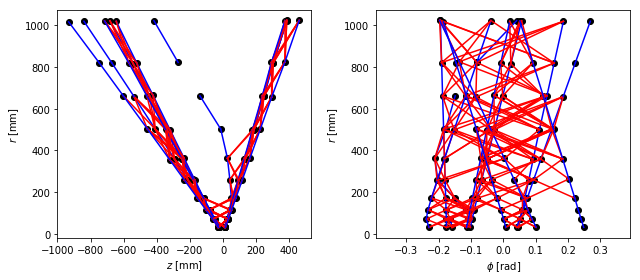

In [9]:
# Pull the inputs from the batcher
g = graph_from_sparse(graphs[0])
draw_sample(g.X*feature_scale, g.Ri, g.Ro, g.y)

In [10]:
'''edges = []
for g in graphs:
    g = graph_from_sparse(g)
    n_edge = g.Ro.shape[1]
    edges.append(n_edge)
bins = np.linspace(min(edges), 
                   max(edges),
                   35)    
plt.hist(edges, bins=bins)
plt.title('Edge Distribution')
plt.xlabel('Edges per Event')
plt.ylabel('Frequency')

plt.show()

print("Average:", round(np.mean(edges), 1), "Standard Deviation:", round(np.std(edges), 1)) '''

'edges = []\nfor g in graphs:\n    g = graph_from_sparse(g)\n    n_edge = g.Ro.shape[1]\n    edges.append(n_edge)\nbins = np.linspace(min(edges), \n                   max(edges),\n                   35)    \nplt.hist(edges, bins=bins)\nplt.title(\'Edge Distribution\')\nplt.xlabel(\'Edges per Event\')\nplt.ylabel(\'Frequency\')\n\nplt.show()\n\nprint("Average:", round(np.mean(edges), 1), "Standard Deviation:", round(np.std(edges), 1)) '

## Train the model

In [9]:
# Model config
hidden_dim = 8
n_iters = 4

# Training config
batch_size = 32

n_epochs = 100
valid_frac = 0.2
test_frac = 0.2

In [10]:
# We round by batch_size to avoid partial batches
n_test = int(n_samples * test_frac) // batch_size * batch_size
n_valid = int(n_samples * valid_frac) // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches = n_test #// batch_size

n_train, n_valid, n_test, n_train + n_valid + n_test

(8512, 2816, 2816, 14144)

In [11]:
# Partition the dataset
train_graphs, test_graphs = train_test_split(graphs, test_size=n_test)
train_graphs, valid_graphs = train_test_split(train_graphs, test_size=n_valid)

print('Train set size:', len(train_graphs))
print('Valid set size:', len(valid_graphs))
print('Test set size: ', len(test_graphs))

Train set size: 8528
Valid set size: 2816
Test set size:  2816


In [12]:
# Prepare the batch generators
train_batcher = batch_generator(train_graphs, n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_graphs, n_samples=n_valid, batch_size=batch_size, train=False)

In [20]:
threshold = 1
%matplotlib inline

model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters, masks_e=None, masks_n=None)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda, l1 = 0)
estim.load_checkpoint('Trainings/hid8l15*3.pt')

def summer(arr, net_name):
    arr_f = arr.flatten()
    sum_n = sum(arr_f)
    print(net_name, 'Network Sum:', sum_n)

with torch.no_grad():
    # Edge Networks
    #print(model.edge_network.network[0].weight)
    #print(model.edge_network.network[0].weight.shape)
    arr_e = torch_to_np(model.edge_network.network[0].weight)
    arr_e = (np.abs(arr_e) > threshold)*1
    summer(arr_e, 'Edge')


    arr_e2 = torch_to_np(model.edge_network.network[2].weight)
    arr_e2 = (np.abs(arr_e2) > threshold)*1
    summer(arr_e2, 'Edge2')
    
    
    # Node Networks
    arr_n = torch_to_np(model.node_network.network[0].weight)
    #print(model.node_network.network[0].weight.shape)
    arr_n = (np.abs(arr_n) > threshold)*1
    summer(arr_n, 'Node')

    
    arr_n2 = torch_to_np(model.node_network.network[2].weight)
    #print(model.node_network.network[2].weight.shape)
    arr_n2 = (np.abs(arr_n2) > threshold)*1
    summer(arr_n2, 'Node2')
    
    mask_e = [np_to_torch(arr_e), np_to_torch(arr_e2)]
    mask_n = [np_to_torch(arr_n), np_to_torch(arr_n2)]

2018-08-01 17:12:32.218912 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): MaskedLinear(in_features=22, out_features=8, bias=True)
      (1): Tanh()
      (2): MaskedLinear(in_features=8, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): MaskedLinear(in_features=33, out_features=8, bias=True)
      (1): Tanh()
      (2): MaskedLinear(in_features=8, out_features=8, bias=True)
      (3): Tanh()
    )
  )
)
2018-08-01 17:12:32.219591 Parameters: 569
Edge Network Sum: 77
Edge2 Network Sum: 8
Node Network Sum: 2
Node2 Network Sum: 7


In [14]:
# Construct the model
model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters, masks_e=mask_e, masks_n=mask_n)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda, l1= 0.00003)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
2018-08-01 17:00:15.886626 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): MaskedLinear(in_features=22, out_features=8, bias=True)
      (1): Tanh()
      (2): MaskedLinear(in_features=8, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): MaskedLinear(in_features=33, out_features=8, bias=True)
      (1): Tanh()
      (2): MaskedLinear(in_features=8, out_features=8, bias=True)
      (3): Tanh()
    )
  )
)
2018-08-01 17:00:15.886968 Parameters: 569


In [15]:
estim.load_weights('Trainings/hid8l15*3.pt')

In [16]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=100,
              valid_generator=valid_batcher, n_valid_batches=n_valid_batches, 
              filename='Trainings/hid8l153mask0_ldweights.pt')

2018-08-01 17:00:30.112676 Epoch 0
2018-08-01 17:00:35.125662   training loss 0.752 time 5.01287s
2018-08-01 17:00:35.957138   validate loss 0.435
2018-08-01 17:00:35.957247  save checkpoint
2018-08-01 17:00:35.959915 Epoch 1
2018-08-01 17:00:40.828588   training loss 0.347 time 4.86859s
2018-08-01 17:00:41.654926   validate loss 0.292
2018-08-01 17:00:41.655360  save checkpoint
2018-08-01 17:00:41.657623 Epoch 2


KeyboardInterrupt: 

In [ ]:
#estim.load_checkpoint('Trainings/hid8l14.pt')

### Loss curves

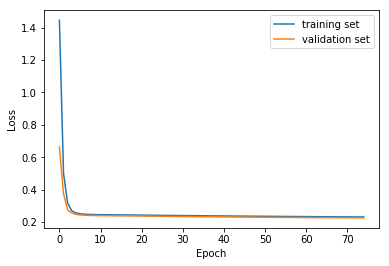

In [45]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xlim(195,300)
#plt.ylim(.06,.08)
plt.legend(loc=0);

## Evaluate model on the test set

In [16]:
if cuda:
    torch.cuda.empty_cache()

In [23]:
estim.load_checkpoint('Trainings/hid8l15*5v2.pt')

In [91]:
# prepare test generator
with torch.no_grad():
    test_batcher = batch_generator(test_graphs, n_samples=n_test, batch_size=1, train=False)
    test_outputs = estim.predict(test_batcher, n_test_batches, concat=False)
    test_preds = [torch_to_np(o) for o in test_outputs]

    # Flatten the predictions and labels
    flat_y = np.concatenate([g.y.flatten() for g in test_graphs])
    flat_pred = np.concatenate([p.flatten() for p in test_preds])
    print(flat_y.shape)
    print(flat_pred.shape)

(699119,)
(699119,)


In [92]:
def makeROC(flat_y, flat_pred, thresh=0.5):
    
    print('Test set results with threshold of', thresh)
    print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
    print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
    print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))
    
    # Compute the ROC curve
    fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)
    
    plt.figure(figsize=(9,2))

    # Plot the model outputs
    plt.subplot(131)
    binning=dict(bins=50, range=(0,1), histtype='bar')
    plt.hist(flat_pred[flat_y<thresh], label='fake', **binning)
    plt.hist(flat_pred[flat_y>thresh], label='true', **binning)
    #plt.xlim(.1,.125)
    plt.xlabel('Model output')
    plt.legend(loc=0)

    # Plot the ROC curve
    plt.subplot(132)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')

    # Plot the ROC curve
    plt.subplot(133)
    plt.semilogx(fpr, tpr)
    #plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.xlim(0, 1)
    plt.title('ROC curve')

    plt.tight_layout()

Test set results with threshold of 0.5
Accuracy:  0.7624
Precision: 0.6421
Recall:    0.7768


/home/ec2-user/miniconda3/envs/pytorch-training/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


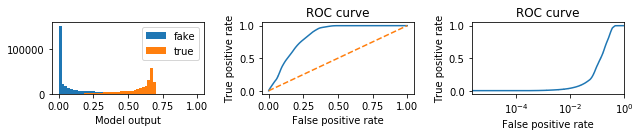

In [93]:
#after training
makeROC(flat_y, flat_pred)

In [125]:
#mask

threshold = .01
%matplotlib inline

def summer(arr, net_name):
    arr_f = arr.flatten()
    sum_n = sum(arr_f)
    print(net_name, 'Network Sum:', sum_n)

with torch.no_grad():
    # Edge Networks
    #print(model.edge_network.network[0].weight)
    print(model.edge_network.network[0].weight.shape)
    arr_e = torch_to_np(model.edge_network.network[0].weight)
    arr_e = (np.abs(arr_e) > threshold)*1
    summer(arr_e, 'Edge')
    # mask
    masked_weight = torch.nn.Parameter(model.edge_network.network[0].weight * np_to_torch(arr_e))
    model.edge_network.network[0].weight = masked_weight
    print(model.edge_network.network[0].weight)

    #arr_e2 = torch_to_np(model.edge_network.network[2].weight)
    print(model.edge_network.network[2].weight.shape)
    # Original size = 32
    arr_e2 = (np.abs(arr_e2) > threshold)*1
    summer(arr_e2, 'Edge2')
    # mask
    masked_weight = torch.nn.Parameter(model.edge_network.network[2].weight * np_to_torch(arr_e2))
    model.edge_network.network[2].weight = masked_weight
    
    # Node Networks
    #arr_n = torch_to_np(model.node_network.network[0].weight)
    print(model.node_network.network[0].weight.shape)
    arr_n = (np.abs(arr_n) > threshold)*1
    summer(arr_n, 'Node')
    # mask
    masked_weight = torch.nn.Parameter(model.node_network.network[0].weight * np_to_torch(arr_n))
    model.node_network.network[0].weight = masked_weight
    
    arr_n2 = torch_to_np(model.node_network.network[2].weight)
    #print(model.node_network.network[2].weight.shape)
    arr_n2 = (np.abs(arr_n2) > threshold)*1
    summer(arr_n2, 'Node2')
    # mask
    masked_weight = torch.nn.Parameter(model.node_network.network[2].weight * np_to_torch(arr_n2))
    model.node_network.network[2].weight = masked_weight

Parameter containing:
tensor([[ 2.1744e-01,  1.6664e-04, -5.2710e-01, -4.9102e-01,  8.4390e-03,
          1.0018e+00, -1.9146e-02, -4.3370e-01, -4.3146e-04,  1.4004e-01,
         -6.0569e-05,  3.3191e-01,  3.1254e-01, -1.4961e-01,  6.9363e-01,
         -3.6197e-01,  2.8552e+00, -3.1378e-04,  8.8049e-02,  4.5248e-01,
          9.9691e-01, -1.5543e-02],
        [-9.9925e-01, -3.4483e-01,  1.4330e-01,  3.4329e+00, -2.4558e+00,
          2.1361e+00, -2.0970e+00,  1.5100e-01,  3.0288e-01, -6.0517e+00,
          7.9162e-02,  9.9303e-01,  1.1525e+00,  1.9254e-04, -4.0482e+00,
          2.3804e+00, -2.7845e+00,  2.1905e+00,  1.2092e-01,  7.9974e-01,
          5.7255e+00, -2.1965e-01],
        [-1.1652e-01, -1.4626e-04,  8.8523e-01,  5.5999e-02,  2.0262e-04,
          2.4337e-01, -4.1754e-01,  1.3412e+00,  5.8769e-01,  1.6895e-04,
          7.6432e-06,  1.1661e+00, -3.2958e-01, -7.4157e-05,  2.8726e-01,
         -5.6915e-01,  1.4692e+00,  8.9548e-01, -4.6404e-01,  1.5221e-01,
         -2.0653e-

In [22]:
#weights

threshold = 0
%matplotlib inline

def summer(arr, net_name):
    arr_f = arr.flatten()
    sum_n = sum(arr_f)
    print(net_name, 'Network Sum:', sum_n)

with torch.no_grad():
    # Edge Networks
    print(model.edge_network.network[0].weight.shape)
    arr_e = torch_to_np(model.edge_network.network[0].weight)
    arr_e = (np.abs(arr_e) > threshold)*1
    summer(arr_e, 'Edge')

    arr_e2 = torch_to_np(model.edge_network.network[2].weight)
    print(model.edge_network.network[2].weight.shape)
    # Original size = 32
    arr_e2 = (np.abs(arr_e2) > threshold)*1
    summer(arr_e2, 'Edge2')
    
    # Node Networks
    arr_n = torch_to_np(model.node_network.network[0].weight)
    print(model.node_network.network[0].weight.shape)
    arr_n = (np.abs(arr_n) > threshold)*1
    summer(arr_n, 'Node')
    print(model.node_network.network[0].weight)
    
    arr_n2 = torch_to_np(model.node_network.network[2].weight)
    print(model.node_network.network[2].weight.shape)
    arr_n2 = (np.abs(arr_n2) > threshold)*1
    summer(arr_n2, 'Node2')

torch.Size([8, 22])
Edge Network Sum: 176
torch.Size([1, 8])
Edge2 Network Sum: 8
torch.Size([8, 33])
Node Network Sum: 264
Parameter containing:
tensor([[-2.0501e-02, -4.7921e-04,  1.7465e-02, -1.6482e-01, -2.1422e-01,
          4.9384e-05,  2.4898e-04, -1.6034e-02,  5.1335e-02,  2.0674e-02,
          7.4121e-05, -1.5306e-01,  1.5821e-01,  2.5952e-02, -1.2329e-01,
         -3.5288e-02, -5.5881e-02, -2.3685e-01,  9.4602e-05,  2.2001e-02,
          5.5670e-02, -1.0403e-04, -6.1945e-02, -8.8800e-01, -1.2895e-01,
         -4.2547e-03,  2.9006e-01,  1.2710e-01, -3.3539e-03, -4.9489e-01,
          2.6876e-01, -4.1347e-01, -6.7567e-05],
        [ 4.9951e-02,  1.7631e-02,  9.7802e-02,  5.8961e-05, -5.8161e-02,
          6.4231e-02,  7.4381e-05,  1.6183e-01,  7.3225e-02, -2.8863e-02,
         -2.8799e-04, -1.4995e-01, -2.1813e-04, -2.7417e-02,  1.1788e-04,
         -7.8508e-02,  1.4344e-01,  1.4921e-02, -5.1964e-02,  3.2584e-02,
         -4.7718e-02,  2.9834e-05,  2.5316e-01,  1.2684e-02,  3.5

In [18]:
%matplotlib inline
 
def plotLayerWeights(layer, plotTitle='Network'):
    with torch.no_grad():
        
        test_batcher = batch_generator(test_graphs, n_samples=1, batch_size=1, train=False)
        test_outputs = estim.predict(test_batcher, 1, concat=False)
        arr = torch_to_np(layer.weight)
        arr = arr.flatten()
        print(arr)

        plt.figure(figsize=(4,4))

        #plt.subplot(2,2,1)
    
        #plt.hist(arr, bins=100, range=(-.0002,.0002))
        #plt.xlabel('Weight')
        #plt.ylabel('Frequency')
        #plt.title('Network')

        #plt.subplot(2,2,2)
        #plt.hist(np.abs(arr), bins=100, range=(0,.0002))
        #plt.xlabel('|Weight|')
        #plt.ylabel('Frequency')
        #plt.title('Network-Absolute Value')

        #plt.subplot(2,2,3)
        #plt.hist(np.abs(arr), bins=1000, range=(2**-11, 2**-0))
        #plt.xscale('log',basex=2)
        #plt.xlim([2**-13,2**-4])
        #plt.xlabel('Weight')
        #plt.ylabel('Frequency')
        #plt.title('Network-Log2')
    
        #plt.subplot(2,2,4)
        #arr_n = [np.log(x) for x in arr_n]
        logbins = np.geomspace(10**-7, 10, 75)
        plt.hist(np.abs(arr), logbins)
        plt.xscale('log',basex=10)
        plt.xlabel('|Weight|')
        plt.ylabel('Frequency')
        plt.title(plotTitle)

        plt.show()

In [61]:
estim.load_weights('Trainings/hid8l153mask0_ldweights.pt')

[-0.03958011 -0.30029535  0.50482583  0.5367185  -0.05980003 -0.42036614
 -0.02413481 -0.337465    0.07741934 -0.48658875  0.22931445  0.05369449
 -0.5133441  -0.02771652 -0.06917405  0.32165933 -0.49135885 -0.2204285
 -0.39742094 -0.4400584  -0.5629088   0.00107455 -0.32388255  0.13829982]


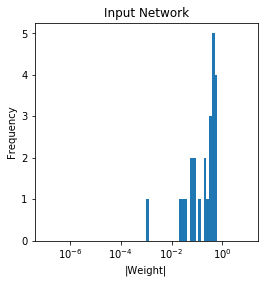

[ 1.5056743e-04  5.5358391e-06 -9.6145773e-01  1.1791045e-04
  1.5523985e-04 -2.2529556e-04 -1.4880358e-01 -1.2221122e+00
  3.1132491e-05  5.3538639e-05  1.9388748e-04  1.0846565e+00
  9.8864930e-06 -1.7881296e-04 -1.4440659e-04 -1.4965271e-04
  1.7145505e+00  4.0529907e-04  1.8191704e-01 -3.0341550e-06
  1.4688078e+00  1.4622392e-04 -1.5834672e+00 -5.7790854e-05
  3.1389558e-04  3.3521764e+00 -1.8445984e+00  2.4041543e+00
 -1.8215759e+00 -1.3697088e-04  7.8356206e-02 -3.8986382e+00
 -9.2148905e-05  2.4289135e-05  1.3617753e+00 -1.0322021e-07
 -3.8506832e+00  2.4357564e+00 -2.5733843e+00  1.8591588e+00
 -2.0521678e-05  1.4735019e-01  4.3851957e+00 -1.5434314e-04
  1.9865598e-04  2.2422703e-04 -4.4614655e-05 -4.0277588e-05
  1.9045026e-04  2.3844838e-04 -1.2630355e+00  1.2361608e+00
  1.5511278e+00 -1.2301441e-04 -2.9655648e-04  1.3478545e+00
 -2.2169173e-02 -2.3460384e-04 -3.5790465e-06  3.2974035e-04
  9.7243807e-05 -4.9225980e-04  2.6288183e-04  1.3518649e-02
  8.5766114e-05  5.78658

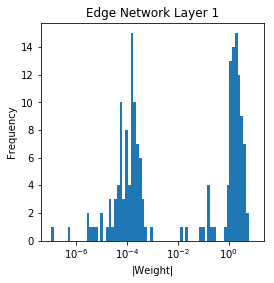

[  5.512026   -6.057954   -4.7897315  -4.651145   -6.13744     8.370598
   8.193315  -11.415647 ]


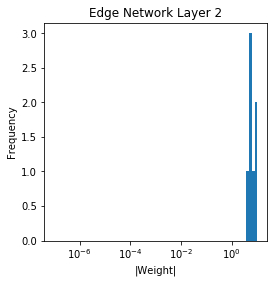

[-1.81178882e-04 -5.00929054e-05  1.63576733e-05 -5.05630378e-05
  3.77266289e-04 -4.01943398e-04  7.31995169e-05 -6.59399302e-05
 -1.35250966e-05 -3.83127190e-05 -1.60441468e-05 -1.29256398e-06
  6.78130236e-05  1.68099388e-04 -4.78133559e-04  4.71168642e-05
 -1.44457663e-04  1.33485300e-04 -4.09724962e-05 -1.15496434e-04
 -3.44531998e-07 -1.47010491e-04  2.36436481e-05 -1.92719817e-01
  1.16967556e-06  2.55739851e-05 -1.92574138e-04 -1.14456598e-04
 -3.36555153e-04  5.77207175e-05  2.57590931e-04 -1.52192442e-04
  4.65813268e-04  1.01271093e-04  2.82538153e-04  4.54940673e-05
  4.46270133e-05 -1.66874524e-04 -5.61623310e-05  1.56803959e-04
 -1.76514732e-04  2.90381540e-05 -1.06800879e-04  2.62509391e-04
  4.41384473e-05 -4.14738934e-05  1.18001088e-04  3.76604039e-05
 -5.94692770e-04 -1.37019728e-04 -9.48439094e-07 -2.77570216e-04
  6.60924416e-05 -1.04070328e-04  8.22029615e-05  4.46738384e-04
 -5.15508000e-05  3.20124527e-04 -1.96723122e-05 -5.66772760e-05
 -2.65848212e-04  1.04136

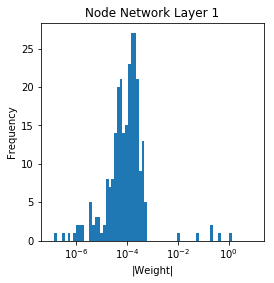

[-8.86786133e-02  6.05377863e-05 -1.14392209e+00  3.12679069e-04
 -9.99619660e-05  1.32256472e+00 -1.22290603e-05  2.17827037e-04
 -3.82456492e-05  3.71271890e-04 -6.73144750e-05 -2.93045849e-01
  2.74489685e-05  5.33821818e-04  2.00705963e-05  1.34958624e-04
 -6.78107321e-01  2.89976448e-01 -1.58522016e-04 -2.50050455e-01
 -1.23798600e-04  7.36630900e-05 -2.15543987e-04  1.42891324e-04
  1.43159544e+00  6.02534965e-05  9.16127028e-05  1.27332663e-04
  1.64678095e-05 -8.47528100e-01  2.61516846e-03 -1.78925133e+00
  1.07700551e-04 -1.80362418e-04  1.77034381e-04  2.91891738e-05
  2.70995748e-04  1.14212349e-01  1.31829560e-01  2.16812432e-01
 -1.43723628e-05 -2.35349231e-04  1.01075682e-04 -1.53816611e-01
 -1.27865278e-05  3.75867312e-05  5.27080381e-04  8.18918634e-04
 -1.53074355e-03 -3.80300917e-04  1.04348706e-04 -2.03571944e-05
  6.07403563e-05  2.26898283e-01 -1.42953708e-04 -1.33587280e-04
 -4.61347960e-02  2.09390193e-01  3.25394474e-04 -1.96073583e-04
  1.12890363e+00  8.31238

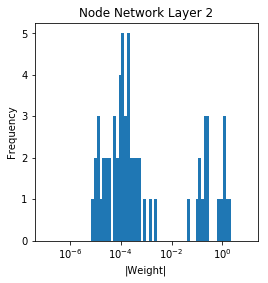

In [19]:
## NETWORKS 
plotLayerWeights(model.input_network[0], plotTitle='Input Network')
plotLayerWeights(model.edge_network.network[0], plotTitle='Edge Network Layer 1')
plotLayerWeights(model.edge_network.network[2], plotTitle='Edge Network Layer 2')
plotLayerWeights(model.node_network.network[0], plotTitle='Node Network Layer 1')
plotLayerWeights(model.node_network.network[2], plotTitle='Node Network Layer 2')

## Visualize some samples

In [ ]:
# Draw some samples
for i in range(4):
    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.precision_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.recall_score(test_y[i], test_pred[i]>thresh)))
    draw_sample(test_X[i]*feature_scale, test_Ri[i], test_Ro[i], test_pred[i], alpha_labels=True);

## Visualize evolution of graph iterations

Let's take a sample and pull out the intermediate edge scores during graph iterations.
I'd like to visualize how the model converges on its chosen edges.

In [ ]:
def graph_iter(model, X, H, Ri, Ro):
    # Shortcut connections
    H = torch.cat([H, X], dim=-1)
    # Edge network
    e = model.edge_network(H, Ri, Ro)
    # Node network
    H = model.node_network(H, e, Ri, Ro)
    return e, H

In [ ]:
batcher = batch_generator(test_X, test_Ri, test_Ro, test_y, train=False,
                          n_samples=1, batch_size=1)

In [ ]:
model = estim.model

In [ ]:
# Pull the inputs from the batcher
(X, Ri, Ro), y = next(batcher)

In [ ]:
# Apply input network
with torch.no_grad():
    H = model.input_network(X)

    for i in range(model.n_iters + 1):
        # Apply an iteration of the graph
        e, H = graph_iter(model, X, H, Ri, Ro)

        # Draw the edges
        draw_sample(torch_to_np(X)[0]*feature_scale,
                    torch_to_np(Ri)[0], torch_to_np(Ro)[0],
                    torch_to_np(e)[0], alpha_labels=True)

## Discussion

On 10 tracks and 10 barrel layers, the performance is great!